In [404]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [405]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 分類数設定

In [406]:
NUM_CLASSES = 4

# 学習データ読み込み

In [407]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [408]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [409]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [410]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(40, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(160, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [411]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_60 (Dropout)        (None, 42)                0         
                                                                 
 dense_78 (Dense)            (None, 40)                1720      
                                                                 
 dropout_61 (Dropout)        (None, 40)                0         
                                                                 
 dense_79 (Dense)            (None, 160)               6560      
                                                                 
 dropout_62 (Dropout)        (None, 160)               0         
                                                                 
 dense_80 (Dense)            (None, 80)                12880     
                                                                 
 dropout_63 (Dropout)        (None, 80)              

In [412]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [413]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [414]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/17 [>.............................] - ETA: 6s - loss: 1.4280 - accuracy: 0.2344
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 1s 14ms/step - loss: 1.3674 - accuracy: 0.3085 - val_loss: 1.2515 - val_accuracy: 0.6428
Epoch 2/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.3176 - accuracy: 0.3750
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 0s 7ms/step - loss: 1.2624 - accuracy: 0.4089 - val_loss: 1.0556 - val_accuracy: 0.6212
Epoch 3/1000
 1/17 [>.............................] - ETA: 0s - loss: 1.1612 - accuracy: 0.4844
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
17/17 [==============================] - 0s 8ms/step - loss: 1.1482 - accuracy: 0.4687 - val_loss: 0.9128 - val_accuracy: 0.5968
Epoch 4/1000
17/17 [==============================] - ETA: 0s - loss: 1.0649 - accuracy: 0.4778


In [415]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

6/6 [==============================] - 0s 2ms/step - loss: 0.2821 - accuracy: 0.9139


In [416]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [417]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[0.01212655 0.029622   0.3880652  0.57018626]
3


# 混同行列

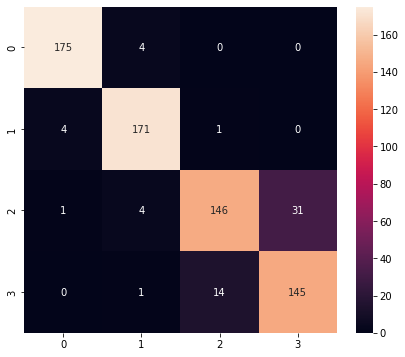

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       179
           1       0.95      0.97      0.96       176
           2       0.91      0.80      0.85       182
           3       0.82      0.91      0.86       160

    accuracy                           0.91       697
   macro avg       0.91      0.91      0.91       697
weighted avg       0.92      0.91      0.91       697



In [418]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [419]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [420]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\you_a\AppData\Local\Temp\tmpzzl1hf7i\assets


INFO:tensorflow:Assets written to: C:\Users\you_a\AppData\Local\Temp\tmpzzl1hf7i\assets


26976

# 推論テスト

In [421]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [422]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [423]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [424]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [425]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[0.01311374 0.03200431 0.3916628  0.5632192 ]
3
